# Air Quality Index prediction based on image data
this model is built based on ResNet. This model have image as the data input. The output of the model is prediction of Air Quality Index (AQI) based on the image data. The dataset contains the data of air quality index in India. The data is collected from various cities in India. The data is collected from the year 2015 to 2020. The data contains the following columns:

In [2]:
import os
import pandas as pd
from datetime import datetime

# Step 1: Read the file names in the image-dataset folder
image_files = os.listdir('image-dataset')
# print(image_files[0][0:15])
# Extract the timestamp from each file name
image_timestamps = [datetime.strptime(os.path.splitext(file)[0][0:15], "%Y%m%d_%H%M%S") for file in image_files]
# print(image_timestamps)

data = {'File Name': image_files, 'Timestamp': image_timestamps}
df_image = pd.DataFrame(data)

# Step 2: Extract the timestamp from each file name
image_timestamps = [os.path.splitext(file)[0] for file in image_files]

# Step 3: Read the AQI dataset
aqi_data = pd.read_csv('aqi-dataset/air_quality_data.csv')

# Step 4: Extract the timestamp from each record in the AQI dataset
# Assuming the timestamp is in a column named 'timestamp'
aqi_timestamps = aqi_data['Now Timestamp'].tolist()

# convert aqi_timestamps to date_time
# aqi_timestamps = [datetime.fromisoformat(timestamp.rsplit(":", 1)[0] + timestamp.rsplit(":", 1)[1]) for timestamp in aqi_timestamps]

# conver aqi_timestamps with this fromat 2024-05-27T10:01:37.112964
aqi_timestamps = [datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%f") for timestamp in aqi_timestamps]

# create nyew dataframe to match aqi_timestamps with aqi_data
data = {'Timestamp': aqi_timestamps, 'AQI': aqi_data['AQI']}
df_aqi = pd.DataFrame(data)
print(df_aqi)

                      Timestamp  AQI
0    2024-05-27 10:01:37.112964   56
1    2024-05-27 10:05:01.186524   56
2    2024-05-27 10:05:21.637891   56
3    2024-05-27 10:05:22.114247   56
4    2024-05-27 10:05:23.235149   56
...                         ...  ...
2057 2024-06-03 13:15:01.172904   82
2058 2024-06-03 13:20:01.068396   82
2059 2024-06-03 13:25:00.751539   82
2060 2024-06-03 13:30:01.331305   82
2061 2024-06-03 13:35:00.982839   82

[2062 rows x 2 columns]


In [3]:
def find_nearest(row, df, column='Timestamp'):
    absolute_difference_function = lambda x: abs(x - row['Timestamp'])
    nearest_timestamp = df[column].apply(absolute_difference_function).idxmin()
    return df.loc[nearest_timestamp]

nearest_aqi = df_image.apply(find_nearest, args=(df_aqi,), axis=1)

# Add the columns from nearest_aqi to df_image
df_image = pd.concat([df_image, nearest_aqi], axis=1)

In [4]:
print(df_image)
df_image.drop(columns=['Timestamp'], inplace=True)
df_image

               File Name           Timestamp                  Timestamp  AQI
0    20240529_153000.jpg 2024-05-29 15:30:00 2024-05-29 15:30:01.270596  114
1    20240527_093000.jpg 2024-05-27 09:30:00 2024-05-27 10:01:37.112964   56
2    20240530_153000.jpg 2024-05-30 15:30:00 2024-05-30 15:30:00.500287  154
3    20240530_083000.jpg 2024-05-30 08:30:00 2024-05-30 08:30:01.371600  154
4    20240528_143000.jpg 2024-05-28 14:30:00 2024-05-28 14:30:01.329125   53
..                   ...                 ...                        ...  ...
187  20240529_080000.jpg 2024-05-29 08:00:00 2024-05-29 08:00:01.004131  134
188  20240601_170000.jpg 2024-06-01 17:00:00 2024-06-01 17:00:01.116007  163
189  20240529_180000.jpg 2024-05-29 18:00:00 2024-05-29 18:00:00.503668  112
190  20240531_110000.jpg 2024-05-31 11:00:00 2024-05-31 11:00:01.072751  122
191  20240527_120000.jpg 2024-05-27 12:00:00 2024-05-27 12:00:00.504816   52

[192 rows x 4 columns]


,File Name,AQI
0,20240529_153000.jpg,114
1,20240527_093000.jpg,56
2,20240530_153000.jpg,154
3,20240530_083000.jpg,154
4,20240528_143000.jpg,53
...,...,...
187,20240529_080000.jpg,134
188,20240601_170000.jpg,163
189,20240529_180000.jpg,112
190,20240531_110000.jpg,122


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_data, test_data = train_test_split(df_image, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=0.2)
test_datagen = ImageDataGenerator(rescale=0.2)

2024-06-06 07:34:54.187253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='image-dataset/',
    x_col='File Name',
    y_col='AQI',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)
test_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='image-dataset/',
    x_col='File Name',
    y_col='AQI',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)


Found 153 validated image filenames.
Found 39 validated image filenames.


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1)(x)  # Single output for AQI

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Summary of the model
model.summary()

2024-06-06 07:34:56.370313: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


234545216/234545216 [==============================] - 11s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // 32,
    validation_data=test_generator,
    validation_steps=len(test_data) // 32,
    epochs=10  # Adjust the number of epochs based on your needs
)

Epoch 1/10


2024-06-06 07:35:17.008840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - ETA: 0s - loss: 72523.0938 - mean_absolute_error: 219.0639 

2024-06-06 07:36:15.563491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 76s 18s/step - loss: 72523.0938 - mean_absolute_error: 219.0639 - val_loss: 65921.4531 - val_mean_absolute_error: 245.8791
Epoch 2/10
4/4 [==============================] - 70s 18s/step - loss: 33974.6328 - mean_absolute_error: 154.0357 - val_loss: 15126.0908 - val_mean_absolute_error: 114.3284
Epoch 3/10
4/4 [==============================] - 63s 16s/step - loss: 21389.8340 - mean_absolute_error: 135.0525 - val_loss: 6330.1904 - val_mean_absolute_error: 47.3111
Epoch 4/10
4/4 [==============================] - 68s 18s/step - loss: 12093.4775 - mean_absolute_error: 84.0942 - val_loss: 14863.6094 - val_mean_absolute_error: 97.1239
Epoch 5/10
4/4 [==============================] - 63s 16s/step - loss: 9714.1367 - mean_absolute_error: 72.5360 - val_loss: 9491.2900 - val_mean_absolute_error: 81.7974
Epoch 6/10
4/4 [==============================] - 75s 20s/step - loss: 8727.0410 - mean_absolute_error: 75.9800 - val_loss: 7192.0073 - val_mean_absolute_

In [18]:
print(history.history)

{'loss': [72523.09375, 33974.6328125, 21389.833984375, 12093.4775390625, 9714.13671875, 8727.041015625, 8063.23974609375, 5462.98193359375, 5226.85986328125, 6033.7333984375], 'mean_absolute_error': [219.06390380859375, 154.03570556640625, 135.052490234375, 84.09420776367188, 72.5360107421875, 75.98002624511719, 60.661415100097656, 50.151546478271484, 49.80696105957031, 51.30846405029297], 'val_loss': [65921.453125, 15126.0908203125, 6330.1904296875, 14863.609375, 9491.2900390625, 7192.00732421875, 8089.3291015625, 5703.7578125, 6831.6943359375, 6100.2255859375], 'val_mean_absolute_error': [245.8790740966797, 114.32839965820312, 47.31111145019531, 97.12386322021484, 81.79735565185547, 53.798927307128906, 59.750343322753906, 43.44099426269531, 51.05047607421875, 45.186004638671875]}


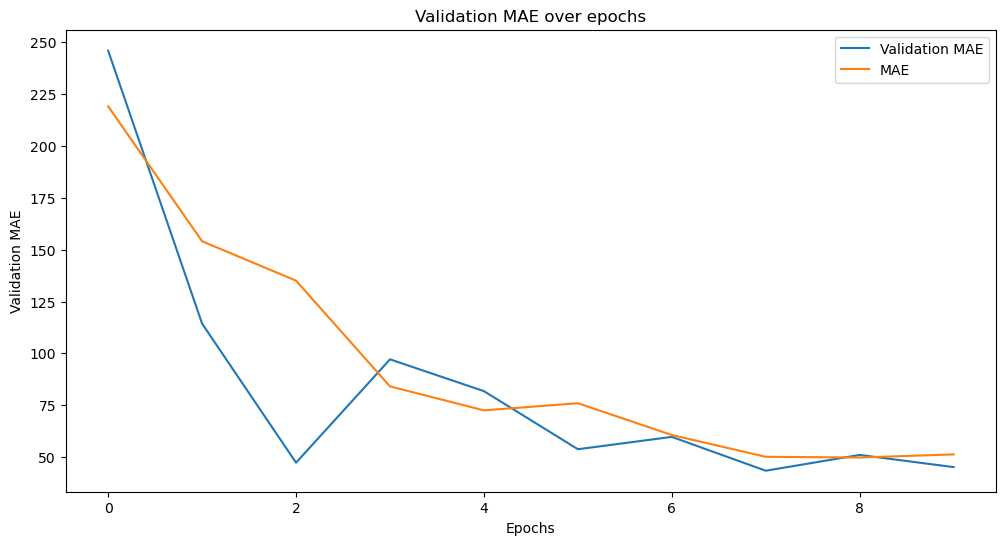

In [20]:
import matplotlib.pyplot as plt

# Assuming history.history['val_mean_absolute_error'] is your data
val_mae = history.history['val_mean_absolute_error']
mae = history.history['mean_absolute_error']

plt.figure(figsize=(12, 6))
plt.plot(val_mae)
plt.plot(mae)
plt.title('Validation MAE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend(['Validation MAE', 'MAE'])
plt.show()

In [11]:
test_loss, test_mae = model.evaluate(test_generator, steps=len(test_data) // 32)
print(f"Test MAE: {test_mae}")

2024-06-06 07:47:32.087086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 14s 14s/step - loss: 6100.2256 - mean_absolute_error: 45.1860
Test MAE: 45.186004638671875


In [12]:
predictions = model.predict(test_generator)

df_result = pd.DataFrame({
    'File Name': test_data['File Name'],
    'Actual AQI': test_data['AQI'],
    'Predicted AQI': predictions.flatten()
})
df_result

2024-06-06 07:47:53.707352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 17s 2s/step


,File Name,Actual AQI,Predicted AQI
45,20240530_150000.jpg,139,107.975296
136,20240601_150000.jpg,147,109.085312
76,20240530_073000.jpg,154,101.807869
143,20240527_140000.jpg,491,106.174164
113,20240531_120000.jpg,153,108.396088
177,20240527_090000.jpg,56,97.532043
15,20240602_170000.jpg,114,106.474930
18,20240602_080000.jpg,159,106.474930
16,20240602_163000.jpg,127,106.474930
9,20240529_103000.jpg,104,107.256638


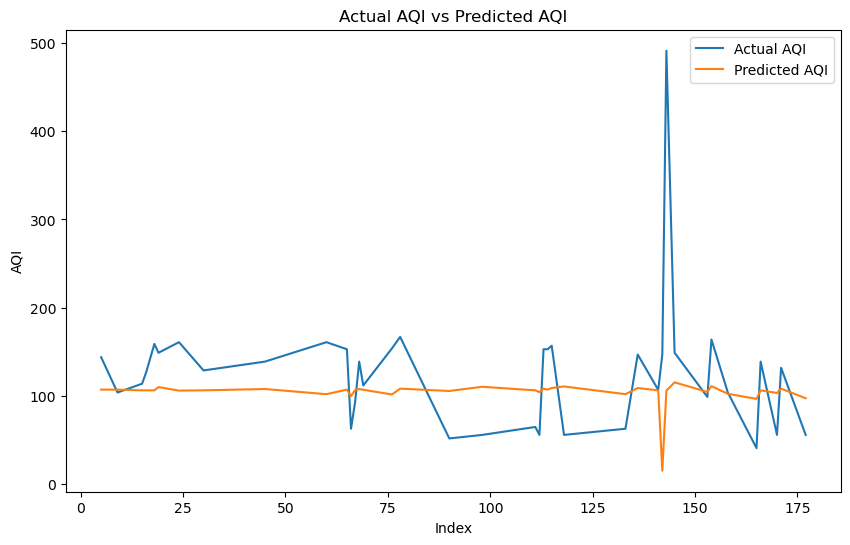

In [13]:
import matplotlib.pyplot as plt

df_result = df_result.sort_index()
# Assuming `df_result` is your DataFrame
plt.figure(figsize=(10, 6))
plt.plot(df_result['Actual AQI'], label='Actual AQI')
plt.plot(df_result['Predicted AQI'], label='Predicted AQI')
plt.title('Actual AQI vs Predicted AQI')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.legend()
plt.show()